# 221 Assignment

### Tobias Reaper

Lambda School Data Science

Unit 2: Predictive Modeling

---
---

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```

---
---

## Assignment

---

#### Imports and Config

In [1]:
# The classix
import pandas as pd
import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Testing out pyjanitor for data wrangling
import janitor

In [3]:
# Plotly imports
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

# Plotly config
# Set plotly to notebook mode / work offline
pyo.init_notebook_mode()

In [4]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [5]:
# Set pandas display options to allow for more columns and rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

In [6]:
# The skool kids
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier

---

#### Do train/validate/test split with the Tanzania Waterpumps data.

In [216]:
DATA_PATH = '../data/'

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [217]:
# Split up train into train and validation
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=92)

---

#### Define a function to wrangle train, validate, and test sets in the same way. 

Clean outliers and engineer features. 

> [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) 

- What other columns are duplicates, or nearly duplicates?
- Can you extract the year from date_recorded?
- Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?

In [10]:
# First, I need a lay o' the data
# train.profile_report(style={"full_width": True})  # Takes a long time with the amount of data / features
train.head()

id  amount_tsh date_recorded                  funder  gps_height  \
22586  11611         0.0    2011-07-12  Government Of Tanzania           0   
47046  10605         0.0    2011-07-13                  Hewasa           0   
2808   64307       500.0    2011-10-04                  Unicef        1506   
3758   64534         0.0    2012-10-22                     Wvt        1375   
57984   1888         0.0    2013-03-16                    Kkkt        1987   

      installer  longitude  latitude       wpt_name  num_private  \
22586       RWE  30.942205 -1.029911           none            0   
47046       DWE  31.479394 -1.375950     Kwa Jofrey            0   
2808        DWE  34.648047 -8.972701      Kwa Mgana            0   
3758        WVT  34.264181 -2.939733       Muungano            0   
57984      KKKT  36.210766 -2.935612  Kwa Kalasinga            0   

               basin subvillage     region  region_code  district_code  \
22586  Lake Victoria    Rutunga     Kagera           18              7   
47046  Lake Victoria    Ruhanga     Kagera           18              2   
2808          Rufiji      Mmana     Iringa           11              4   
3758   Lake Victoria  Mwaburugu  Shinyanga           17              1   
57984       Internal   King'Una     Arusha            2              6   

                lga        ward  population public_meeting  \
22586       Misenyi     Ruzinga           0           True   
47046  Bukoba Rural      Katoro           0           True   
2808         Njombe       Usuka         150           True   
3758        Bariadi      Mhunze         500           True   
57984       Longido  Ketumbeine         250           True   

                   recorded_by scheme_management                  scheme_name  \
22586  GeoData Consultants Ltd             Other                          Ruz   
47046  GeoData Consultants Ltd               VWC        KATORO PUMPING SCHEME   
2808   GeoData Consultants Ltd               WUA  wanging'ombe water supply s   
3758   GeoData Consultants Ltd               WUG                          NaN   
57984  GeoData Consultants Ltd               NaN   Elang'atadapash water proj   

      permit  construction_year extraction_type extraction_type_group  \
22586   True                  0             ksb           submersible   
47046   True                  0          swn 80                swn 80   
2808    True               1984         gravity               gravity   
3758   False               2007     nira/tanira           nira/tanira   
57984    NaN               2001         gravity               gravity   

      extraction_type_class management management_group  \
22586           submersible        vwc       user-group   
47046              handpump        vwc       user-group   
2808                gravity        wua       user-group   
3758               handpump        wug       user-group   
57984               gravity        vwc       user-group   

                     payment payment_type water_quality quality_group  \
22586              never pay    never pay          soft          good   
47046              never pay    never pay          soft          good   
2808             pay monthly      monthly          soft          good   
3758               never pay    never pay          soft          good   
57984  pay when scheme fails   on failure          soft          good   

           quantity quantity_group        source   source_type source_class  \
22586  insufficient   insufficient        spring        spring  groundwater   
47046        enough         enough  shallow well  shallow well  groundwater   
2808         enough         enough         river    river/lake      surface   
3758         enough         enough  shallow well  shallow well  groundwater   
57984  insufficient   insufficient         river    river/lake      surface   

          waterpoint_type waterpoint_type_group             status_group  
22586  communal standpipe    communal standp

In [11]:
train.describe().T

count          mean           std       min  \
id                 47520.0  37155.399516  21427.799609   0.00000   
amount_tsh         47520.0    314.486718   2724.873747   0.00000   
gps_height         47520.0    668.902967    694.476741 -90.00000   
longitude          47520.0     34.087278      6.529408   0.00000   
latitude           47520.0     -5.705246      2.944327 -11.64944   
num_private        47520.0      0.493455     13.030960   0.00000   
region_code        47520.0     15.313237     17.600399   1.00000   
district_code      47520.0      5.615278      9.589551   0.00000   
population         47520.0    179.241098    474.443279   0.00000   
construction_year  47520.0   1299.298022    952.032486   0.00000   

                            25%           50%           75%           max  
id                 18633.250000  37098.500000  55669.500000  7.424700e+04  
amount_tsh             0.000000      0.000000     20.000000  2.500000e+05  
gps_height             0.000000    366.000000   1321.000000  2.770000e+03  
longitude             33.092142     34.898884     37.171474  4.034519e+01  
latitude              -8.546904     -5.016939     -3.325370 -2.000000e-08  
num_private            0.000000      0.000000      0.000000  1.776000e+03  
region_code            5.000000     12.000000     17.000000  9.900000e+01  
district_code          2.000000      3.000000      5.000000  8.000000e+01  
population             0.000000     25.000000    212.000000  3.050000e+04  
construction_year      0.000000   1986.000000   2004.000000  2.013000e+03

In [12]:
train.isnull().sum()

id                           0
amount_tsh                   0
date_recorded                0
funder                    2903
gps_height                   0
installer                 2918
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 297
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            2632
recorded_by                  0
scheme_management         3104
scheme_name              22571
permit                    2461
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

In [13]:
# Check out non-numeric columns, sorted by unique values
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

count unique                      top   freq
recorded_by            47520      1  GeoData Consultants Ltd  47520
public_meeting         44888      2                     True  40845
permit                 45059      2                     True  31097
status_group           47520      3               functional  25807
source_class           47520      3              groundwater  36731
quantity_group         47520      5                   enough  26613
quantity               47520      5                   enough  26613
management_group       47520      5               user-group  42005
quality_group          47520      6                     good  40671
waterpoint_type_group  47520      6       communal standpipe  27661
waterpoint_type        47520      7       communal standpipe  22809
payment_type           47520      7                never pay  20386
extraction_type_class  47520      7                  gravity  21417
source_type            47520      7                   spring  13702
payment                47520      7                never pay  20386
water_quality          47520      8                     soft  40671
basin                  47520      9            Lake Victoria   8246
source                 47520     10                   spring  13702
scheme_management      44416     12                      VWC  29481
management             47520     12                      vwc  32477
extraction_type_group  47520     13                  gravity  21417
extraction_type        47520     17                  gravity  21417
region                 47520     21                   Iringa   4280
lga                    47520    125                   Njombe   2024
date_recorded          47520    349               2011-03-17    456
funder                 44617   1696   Government Of Tanzania   7328
installer              44602   1907                      DWE  13934
ward                   47520   2084                    Igosi    257
scheme_name            24949   2553                        K    553
subvillage             47223  17295                 Madukani    412
wpt_name               47520  30706                     none   2872

In [218]:
def wrangle(data):
    """Acts as a virtual lasso for consistently wrangling train, validation, and test data."""
    
    # Make a copy to prevent "SettingWithCopyWarning"
    data = data.copy()
    
    drop_cols = [
        "wpt_name",
        "scheme_name",
        "ward",
        "funder",
        "region_code",
        "quantity_group",
        "payment",
        "extraction_type_group",
        "extraction_type_class",
        "waterpoint_type_group",
        "source_type",
        "quality_group",
        "scheme_management",
        "recorded_by",
        "num_private",
    ]
    
    high_card = [
        "subvillage",
        "installer",
        "lga"
    ]
    
    for feature in high_card:
        top10 = data[feature].value_counts()[:10].index  # Top 10 categories
        # Replace cells not in the top 10 of each category with "Other"
        data.loc[~data[feature].isin(top10), feature] = "Other"

    # Use pyjanitor's method chaining to clean up data
    data = (data
            .drop(columns=drop_cols)
            .find_replace("latitude", {-2e-08: np.nan})
            .find_replace("longitude", {0: np.nan})
            .find_replace("construction_year", {0: np.nan})
            .find_replace("district_code", {0: np.nan})
            .find_replace("population", {0: np.nan})
            .find_replace("amount_tsh", {0: np.nan})
            .to_datetime("date_recorded")
           )
    
    # List of features to have null values replaced with mean of region
    impute_list = [
        "amount_tsh",
        "population",
        "latitude",
        "longitude",
        "construction_year",
        "gps_height",
    ]
    
    for feature in impute_list:
        lookup = data[feature].groupby(by=data["region"]).mean()  # Create lookup of means by region
        nulls = data.loc[data[feature].isnull(), "region"]  # Locate the null values in the target column
        data.loc[data[feature].isnull(), feature] = lookup.loc[nulls].values  # Replace the nulls with the corresponding lookup

    # Feature engineering
    data["year_recorded"] = data["date_recorded"].dt.year
    data["age_at_inspection"] = data["year_recorded"] - data["construction_year"]

    # Drop the "date_recorded" column after extracting the year
    data = data.drop(columns=["date_recorded"])
    
    # return the wrangled dataframe
    return data

In [219]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [220]:
# Take another look at null values now that they've been replaced
train.isnull().sum()

id                      0
amount_tsh           9690
gps_height              0
installer               0
longitude               0
latitude                0
basin                   0
subvillage              0
region                  0
district_code          19
lga                     0
population           9690
public_meeting       2632
permit               2461
construction_year    9690
extraction_type         0
management              0
management_group        0
payment_type            0
water_quality           0
quantity                0
source                  0
source_class            0
waterpoint_type         0
status_group            0
year_recorded           0
age_at_inspection    9690
dtype: int64

In [221]:
train.head()

id   amount_tsh  gps_height installer  longitude  latitude  \
22586  11611          NaN         0.0       RWE  30.942205 -1.029911   
47046  10605          NaN         0.0       DWE  31.479394 -1.375950   
2808   64307   500.000000      1506.0       DWE  34.648047 -8.972701   
3758   64534   480.000000      1375.0     Other  34.264181 -2.939733   
57984   1888  1232.791495      1987.0      KKKT  36.210766 -2.935612   

               basin subvillage     region  district_code      lga  \
22586  Lake Victoria      Other     Kagera            7.0    Other   
47046  Lake Victoria      Other     Kagera            2.0    Other   
2808          Rufiji      Other     Iringa            4.0   Njombe   
3758   Lake Victoria      Other  Shinyanga            1.0  Bariadi   
57984       Internal      Other     Arusha            6.0    Other   

       population public_meeting permit  construction_year extraction_type  \
22586         NaN           True   True                NaN             ksb   
47046         NaN           True   True                NaN          swn 80   
2808        150.0           True   True             1984.0         gravity   
3758        500.0           True  False             2007.0     nira/tanira   
57984       250.0           True    NaN             2001.0         gravity   

      management management_group payment_type water_quality      quantity  \
22586        vwc       user-group    never pay          soft  insufficient   
47046        vwc       user-group    never pay          soft        enough   
2808         wua       user-group      monthly          soft        enough   
3758         wug       user-group    never pay          soft        enough   
57984        vwc       user-group   on failure          soft  insufficient   

             source source_class     waterpoint_type             status_group  \
22586        spring  groundwater  communal standpipe           non functional   
47046  shallow well  groundwater           hand pump               functional   
2808          river      surface  communal standpipe  functional needs repair   
3758   shallow well  groundwater           hand pump               functional   
57984         river      surface  communal standpipe               functional   

       year_recorded  age_at_inspection  
22586           2011                NaN  
47046           2011                NaN  
2808            2011               27.0  
3758            2012                5.0  
57984           2013               12.0

In [222]:
# Check out non-numeric columns, sorted by unique values
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

count unique                 top   freq
public_meeting    44888      2                True  40845
permit            45059      2                True  31097
status_group      47520      3          functional  25807
source_class      47520      3         groundwater  36731
quantity          47520      5              enough  26613
management_group  47520      5          user-group  42005
waterpoint_type   47520      7  communal standpipe  22809
payment_type      47520      7           never pay  20386
water_quality     47520      8                soft  40671
basin             47520      9       Lake Victoria   8246
source            47520     10              spring  13702
installer         47520     11               Other  26349
lga               47520     11               Other  37568
subvillage        47520     11               Other  45068
management        47520     12                 vwc  32477
extraction_type   47520     17             gravity  21417
region            47520     21              Iringa   4280

In [223]:
train.describe().T

count          mean           std          min  \
id                 47520.0  37155.399516  21427.799609     0.000000   
amount_tsh         37830.0    936.261038   3035.803428     0.200000   
gps_height         47520.0    668.902967    694.476741   -90.000000   
longitude          47520.0     35.085618      2.587480    29.607122   
latitude           47520.0     -5.798528      2.809066   -11.649440   
district_code      47501.0      5.617524      9.590810     1.000000   
population         37830.0    307.474436    516.313040     1.000000   
construction_year  37830.0   1997.215341     11.432899  1960.000000   
year_recorded      47520.0   2011.917298      0.956964  2002.000000   
age_at_inspection  37830.0     14.891161     11.435738    -7.000000   

                            25%           50%           75%            max  
id                 18633.250000  37098.500000  55669.500000   74247.000000  
amount_tsh           300.000000    602.043611   1000.000000  250000.000000  
gps_height             0.000000    366.000000   1321.000000    2770.000000  
longitude             33.225428     34.898884     37.171474      40.345193  
latitude              -8.546904     -5.016939     -3.356230      -0.998464  
district_code          2.000000      3.000000      5.000000      80.000000  
population            56.000000    200.000000    426.480916   30500.000000  
construction_year   1992.000000   2000.000000   2006.000000    2013.000000  
year_recorded       2011.000000   2012.000000   2013.000000    2013.000000  
age_at_inspection      6.000000     12.000000     21.000000      53.000000

In [224]:
# Look at profile_report
train.profile_report(style={"full_width": True})

---

#### Select features. 

Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.


In [457]:
# Define target
target = "status_group"

# Features dataframe with all columns except target and id
features = train.drop(columns=[target, "id"]).columns.tolist()

features

['amount_tsh',
 'gps_height',
 'installer',
 'longitude',
 'latitude',
 'basin',
 'subvillage',
 'region',
 'district_code',
 'lga',
 'population',
 'public_meeting',
 'permit',
 'construction_year',
 'extraction_type',
 'management',
 'management_group',
 'payment_type',
 'water_quality',
 'quantity',
 'source',
 'source_class',
 'waterpoint_type',
 'year_recorded',
 'age_at_inspection']

In [458]:
# Arrange data into X features matrices and y target vectors
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [465]:
# Use a scikit-learn pipeline to encode the data and impute missing values
# Then instantiate the Decision Tree model
tree_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(strategy="mean"),
    DecisionTreeClassifier(max_depth=20, min_samples_leaf=8, random_state=92)  # best val accuracy is .7718
)

In [466]:
# Fit the decision tree model on training data
tree_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['installer', 'basin', 'subvillage',
                                     'region', 'lga', 'public_meeting',
                                     'permit', 'extraction_type', 'management',
                                     'management_group', 'payment_type',
                                     'water_quality', 'quantity', 'source',
                                     'source_class', 'waterpoint_type'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df...
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight=None, criterion='gini',
                                        max_depth=20, max_features=None,
                                        max_lea

---

#### Get your validation accuracy score.

In [467]:
# Score on training and validation sets
print("Train accuracy:", tree_pipeline.score(X_train, y_train))
print("Validation accuracy:", tree_pipeline.score(X_val, y_val))

Train accuracy: 0.8278829966329966
Validation accuracy: 0.7718013468013468


---

#### Get and plot your feature importances.

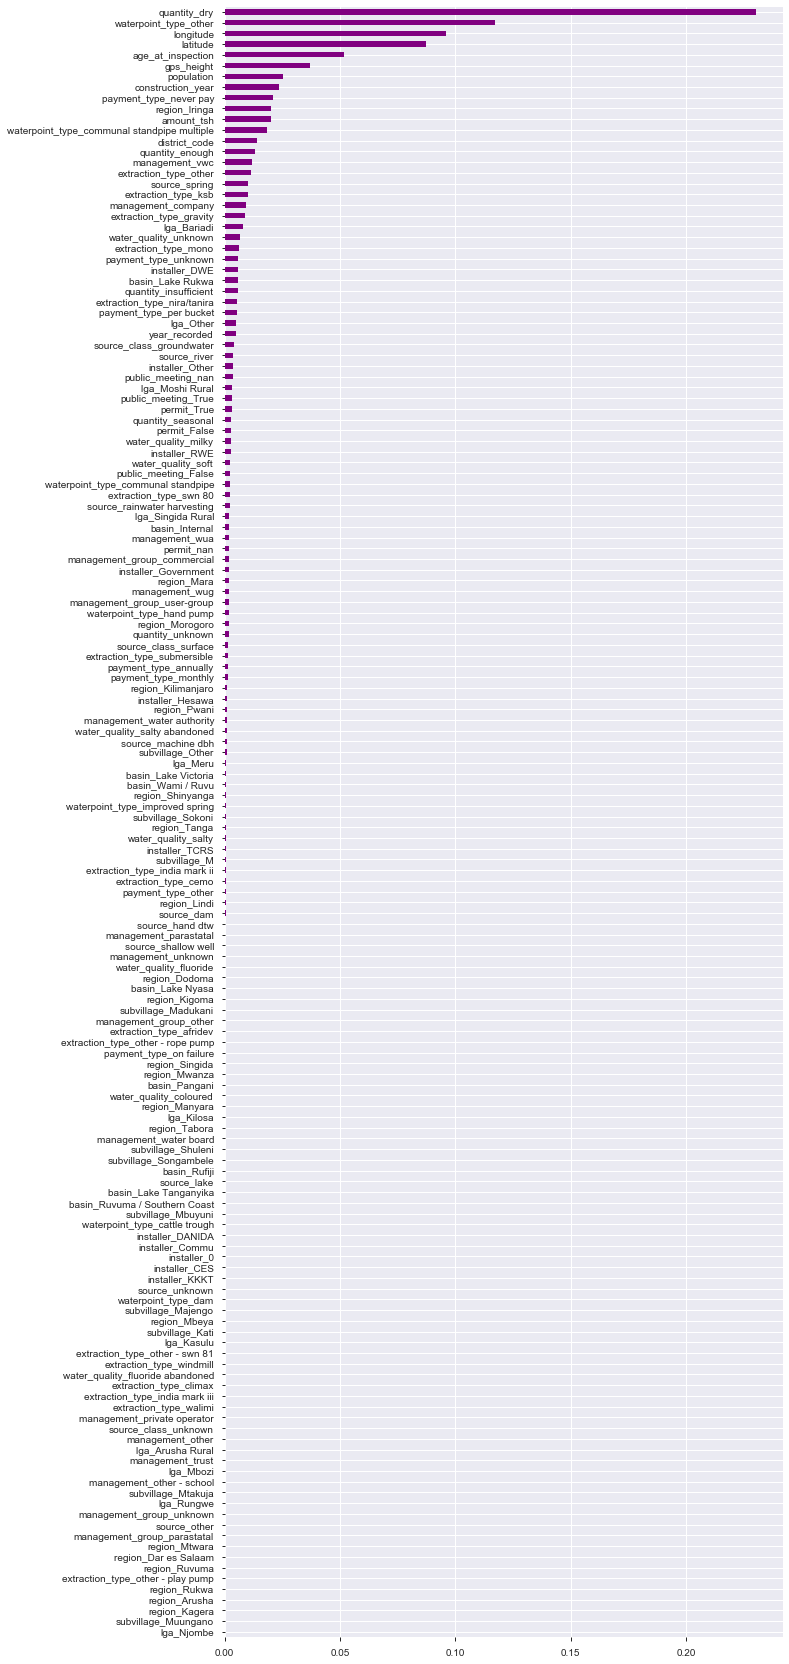

In [468]:
# Extract feature importances

model = tree_pipeline.named_steps["decisiontreeclassifier"]

encoder = tree_pipeline.named_steps["onehotencoder"]
encoded_columns = encoder.transform(X_val).columns

importances = pd.Series(model.feature_importances_, encoded_columns)

plt.figure(figsize=(10, 30))
importances.sort_values().plot.barh(color="purple");

---

#### Submit your predictions to our Kaggle competition.

(Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)

In [182]:
# Make the predictions based on testing data
y_pred = tree_pipeline.predict(X_test)
y_pred_series = pd.Series(y_pred)

In [183]:
y_pred_series.value_counts()

functional                 8816
non functional             4983
functional needs repair     559
dtype: int64

In [184]:
# Makes dataframe with id and status_group
submission = sample_submission.copy()
submission["status_group"] = y_pred_series

In [185]:
# Write submission to csv without the index
submission.to_csv("tobias-reaper-waterpump-submission-2.csv", index=False)

---

#### Commit your notebook to your fork of the GitHub repo.